In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

**Dataset preparation**

In [3]:
#Loading
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data 

x_train= x_train / 255.0
x_test = x_test / 255.0
 
# One-hot encode labels
num_labels = 10
y_train=one_hot(y_train.astype('int32'),num_labels)
y_test=one_hot(y_test.astype('int32'),num_labels)


x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


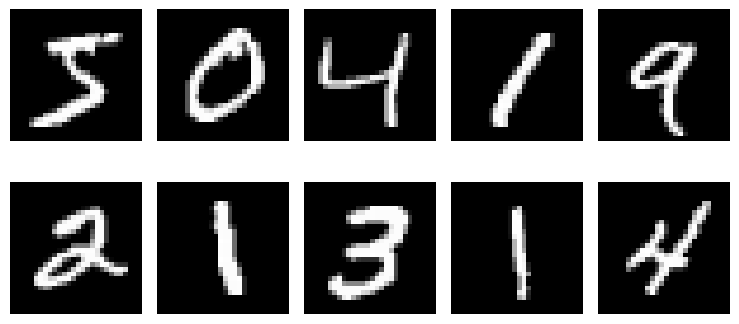

In [4]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

**Initialization**

In [5]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        # Momentum için
        self.momemtum_opt = {key: np.zeros_like(value) for key, value in self.params.items()}

        # RMSProp için
        self.rmsprop_cache = {key: np.zeros_like(value) for key, value in self.params.items()}

        # Adam için
        self.adam_m = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.adam_v = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.t = 1  # Başlangıç iterasyon sayısı

        
    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)


    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        x = np.clip(x, -500, 500)  # Clipping to avoid overflow
        sig = 1 / (1 + np.exp(-x))
    
        if derivative:
           return sig * (1 - sig)
    
        return sig
    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        x = x - np.max(x, axis=0, keepdims=True)
        exps = np.exp(x)
        return exps / np.sum(exps, axis=0, keepdims=True)


    def initialize(self):
        input_layer = self.sizes[0]
        hidden_layer = self.sizes[1]
        output_layer = self.sizes[2]
    
        return {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1. / input_layer),  # Xavier initialization
            "b1": np.zeros((hidden_layer, 1)),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1. / hidden_layer),  # Xavier initialization
            "b2": np.zeros((output_layer, 1))
         }
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
       
    def back_propagate(self, y, output):
           ''' This is the backpropagation algorithm, for calculating the updates of the neural network's parameters. '''
           current_batch_size = y.shape[0]
    
           dZ2 = output - y.T
           dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T) + self.lambda2 * self.params["W2"] + self.lambda1 * np.sign(self.params["W2"])
           db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

           dA1 = np.matmul(self.params["W2"].T, dZ2)
           dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
           dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"]) + self.lambda2 * self.params["W1"] + self.lambda1 * np.sign(self.params["W1"])
           db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

           self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
           return self.grads
    
    def cross_entropy_loss(self, y, output, lambda1, lambda2):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        epsilon = 1e-12  # Small constant to prevent log(0)
        output = np.clip(output, epsilon, 1. - epsilon)  # Clip output
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
    
    # Add L1 and L2 regularization terms
        l1_regularization = lambda1 * (np.sum(np.abs(self.params["W1"])) + np.sum(np.abs(self.params["W2"])))
        l2_regularization = lambda2 * (np.sum(np.square(self.params["W1"])) + np.sum(np.square(self.params["W2"])))
    
        return l + l1_regularization + l2_regularization
    # Add L1 and L2 regularization terms
        l1_regularization = lambda1 * (np.sum(np.abs(self.params["W1"])) + np.sum(np.abs(self.params["W2"])))
        l2_regularization = lambda2 * (np.sum(np.square(self.params["W1"])) + np.sum(np.square(self.params["W2"])))
    
        return l + l1_regularization + l2_regularization
    def optimize_rmsprop(self, l_rate=0.001, beta=0.9, epsilon=1e-8):
        for key in self.params:
            self.rmsprop_cache[key] = beta * self.rmsprop_cache[key] + (1 - beta) * (self.grads[key] ** 2)
            self.params[key] -= l_rate * self.grads[key] / (np.sqrt(self.rmsprop_cache[key]) + epsilon)
    def optimize_adam(self, l_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        for key in self.params:
            self.adam_m[key] = beta1 * self.adam_m[key] + (1 - beta1) * self.grads[key]
            self.adam_v[key] = beta2 * self.adam_v[key] + (1 - beta2) * (self.grads[key] ** 2)
        
            m_hat = self.adam_m[key] / (1 - beta1 ** self.t)
            v_hat = self.adam_v[key] / (1 - beta2 ** self.t)
        
            self.params[key] -= l_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        self.t += 1
                
    def optimize(self, l_rate=0.1, beta=.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        elif self.optimizer == "RMSProp":
            self.optimize_rmsprop(l_rate=l_rate, beta=beta, epsilon=epsilon)
        elif self.optimizer == "adam":
            self.optimize_adam(l_rate=l_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01):
        # Hyperparameters
        self.epochs = epochs
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
            
        train_acc_history = []
        test_acc_history = []
        
        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

           # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output, lambda1, lambda2)
            train_acc_history.append(train_acc)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output, lambda1, lambda2)
            test_acc_history.append(test_acc)
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))
        
        # Plot accuracy graph
        epochs_range = range(1, self.epochs + 1)
        plt.plot(epochs_range, train_acc_history, label='Train Accuracy')
        plt.plot(epochs_range, test_acc_history, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Testing Accuracy over Epochs')
        plt.legend()
        plt.show()

Epoch 1: 1.61s, train acc=0.79, train loss=2.13, test acc=0.80, test loss=2.10
Epoch 2: 3.17s, train acc=0.78, train loss=2.26, test acc=0.78, test loss=2.23
Epoch 3: 4.71s, train acc=0.77, train loss=2.31, test acc=0.78, test loss=2.28
Epoch 4: 6.25s, train acc=0.78, train loss=2.31, test acc=0.78, test loss=2.28
Epoch 5: 8.70s, train acc=0.78, train loss=2.31, test acc=0.79, test loss=2.28
Epoch 6: 10.63s, train acc=0.78, train loss=2.30, test acc=0.78, test loss=2.27
Epoch 7: 12.14s, train acc=0.78, train loss=2.31, test acc=0.78, test loss=2.28
Epoch 8: 13.64s, train acc=0.78, train loss=2.32, test acc=0.79, test loss=2.29
Epoch 9: 15.13s, train acc=0.78, train loss=2.34, test acc=0.78, test loss=2.31
Epoch 10: 16.61s, train acc=0.78, train loss=2.33, test acc=0.79, test loss=2.30


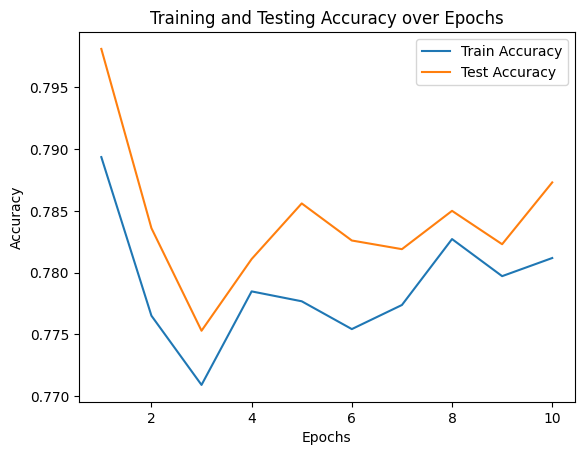

In [6]:
#ReLU+ momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 1.88s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 2: 3.82s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 3: 5.75s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 4: 7.70s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 5: 9.64s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 6: 11.70s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 7: 13.64s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 8: 15.58s, train acc=0.11, train loss=2.37, test acc=0.11, test loss=2.37
Epoch 9: 17.53s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36
Epoch 10: 19.53s, train acc=0.11, train loss=2.36, test acc=0.11, test loss=2.36


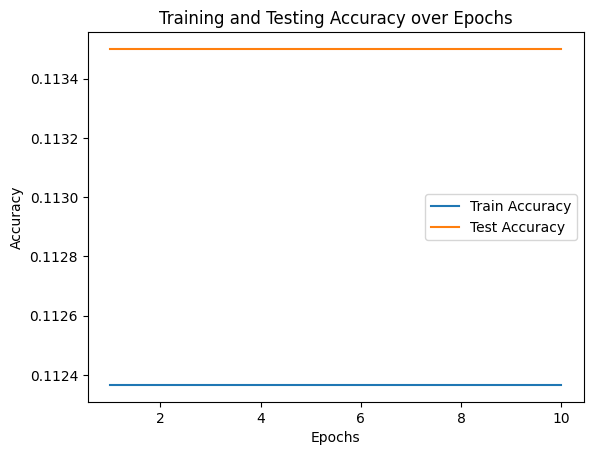

In [7]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 1.82s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56
Epoch 2: 3.69s, train acc=0.10, train loss=2.57, test acc=0.10, test loss=2.57
Epoch 3: 6.56s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56
Epoch 4: 8.34s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56
Epoch 5: 10.11s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56
Epoch 6: 11.91s, train acc=0.10, train loss=2.56, test acc=0.10, test loss=2.56
Epoch 7: 13.70s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56
Epoch 8: 15.48s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56
Epoch 9: 17.26s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.57
Epoch 10: 19.04s, train acc=0.11, train loss=2.56, test acc=0.11, test loss=2.56


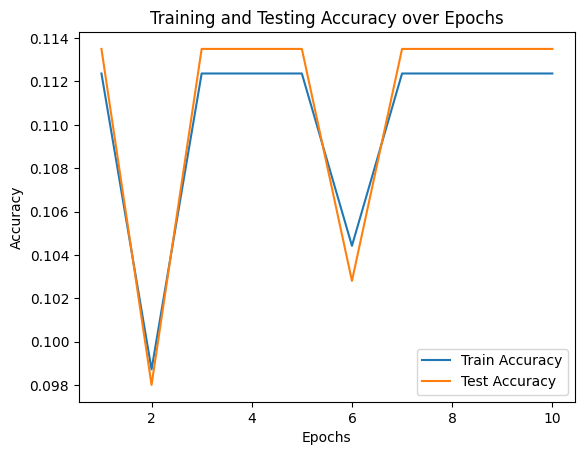

In [8]:
# Sigmoid + sgd
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 1.50s, train acc=0.75, train loss=2.32, test acc=0.76, test loss=2.30
Epoch 2: 2.94s, train acc=0.79, train loss=2.33, test acc=0.79, test loss=2.31
Epoch 3: 4.35s, train acc=0.80, train loss=2.43, test acc=0.80, test loss=2.41
Epoch 4: 5.76s, train acc=0.80, train loss=2.53, test acc=0.81, test loss=2.51
Epoch 5: 7.17s, train acc=0.80, train loss=2.65, test acc=0.80, test loss=2.63
Epoch 6: 8.59s, train acc=0.79, train loss=2.77, test acc=0.79, test loss=2.75
Epoch 7: 10.01s, train acc=0.78, train loss=3.04, test acc=0.79, test loss=3.02
Epoch 8: 11.58s, train acc=0.78, train loss=3.29, test acc=0.79, test loss=3.26
Epoch 9: 12.99s, train acc=0.78, train loss=3.39, test acc=0.78, test loss=3.37
Epoch 10: 14.40s, train acc=0.77, train loss=3.47, test acc=0.78, test loss=3.45


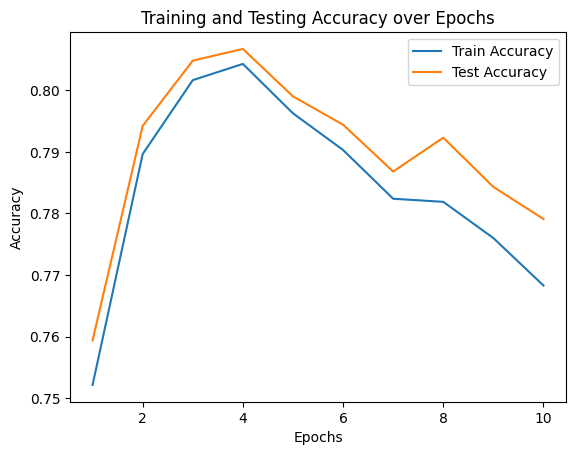

In [9]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 2.04s, train acc=0.18, train loss=29.01, test acc=0.18, test loss=29.01
Epoch 2: 5.03s, train acc=0.18, train loss=29.04, test acc=0.18, test loss=29.05
Epoch 3: 7.33s, train acc=0.18, train loss=29.17, test acc=0.18, test loss=29.17
Epoch 4: 9.36s, train acc=0.10, train loss=29.01, test acc=0.10, test loss=29.01
Epoch 5: 11.38s, train acc=0.11, train loss=29.01, test acc=0.11, test loss=29.01
Epoch 6: 13.45s, train acc=0.11, train loss=29.01, test acc=0.11, test loss=29.01
Epoch 7: 15.52s, train acc=0.11, train loss=29.15, test acc=0.11, test loss=29.15
Epoch 8: 17.72s, train acc=0.10, train loss=29.02, test acc=0.10, test loss=29.02
Epoch 9: 19.80s, train acc=0.10, train loss=29.01, test acc=0.10, test loss=29.01
Epoch 10: 21.88s, train acc=0.10, train loss=28.99, test acc=0.10, test loss=28.99


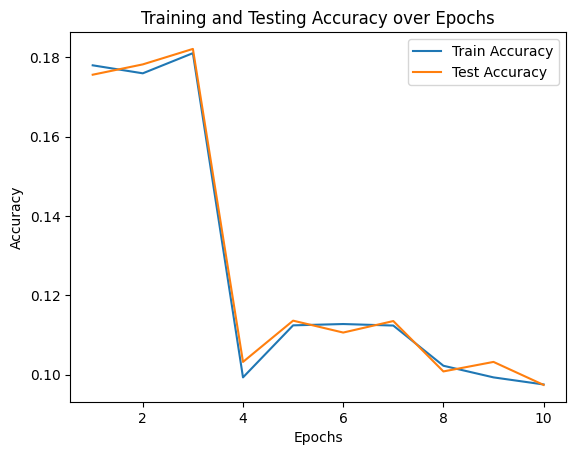

In [10]:
# Sigmoid + RSMProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='RMSProp', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 1.67s, train acc=0.37, train loss=38.74, test acc=0.37, test loss=38.73
Epoch 2: 3.36s, train acc=0.29, train loss=38.18, test acc=0.29, test loss=38.17
Epoch 3: 5.13s, train acc=0.31, train loss=35.89, test acc=0.32, test loss=35.86
Epoch 4: 6.80s, train acc=0.34, train loss=34.72, test acc=0.34, test loss=34.70
Epoch 5: 8.46s, train acc=0.41, train loss=35.24, test acc=0.42, test loss=35.23
Epoch 6: 10.08s, train acc=0.34, train loss=37.44, test acc=0.34, test loss=37.45
Epoch 7: 11.72s, train acc=0.26, train loss=39.10, test acc=0.26, test loss=39.10
Epoch 8: 13.35s, train acc=0.16, train loss=36.62, test acc=0.16, test loss=36.62
Epoch 9: 16.17s, train acc=0.26, train loss=36.90, test acc=0.26, test loss=36.97
Epoch 10: 17.95s, train acc=0.31, train loss=35.98, test acc=0.31, test loss=35.97


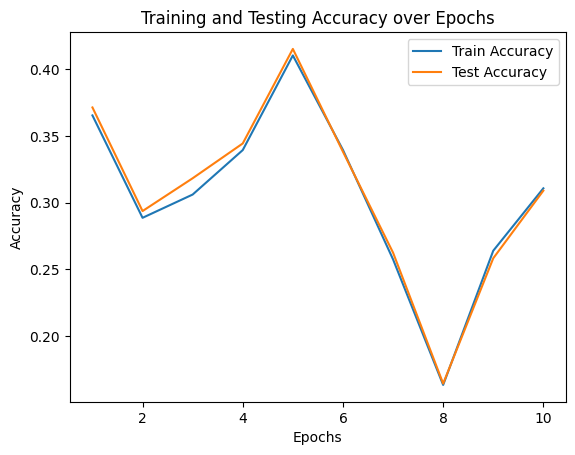

In [11]:
# ReLU + RMSProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='RMSProp', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 2.21s, train acc=0.27, train loss=10.43, test acc=0.27, test loss=10.42
Epoch 2: 4.49s, train acc=0.28, train loss=9.97, test acc=0.28, test loss=9.96
Epoch 3: 6.90s, train acc=0.30, train loss=7.74, test acc=0.30, test loss=7.74
Epoch 4: 9.18s, train acc=0.29, train loss=8.93, test acc=0.29, test loss=8.92
Epoch 5: 11.47s, train acc=0.30, train loss=10.60, test acc=0.30, test loss=10.59
Epoch 6: 13.76s, train acc=0.26, train loss=10.15, test acc=0.26, test loss=10.14
Epoch 7: 16.13s, train acc=0.30, train loss=7.74, test acc=0.31, test loss=7.73
Epoch 8: 18.39s, train acc=0.29, train loss=8.73, test acc=0.29, test loss=8.72
Epoch 9: 20.69s, train acc=0.27, train loss=10.56, test acc=0.27, test loss=10.55
Epoch 10: 23.06s, train acc=0.22, train loss=10.23, test acc=0.22, test loss=10.22


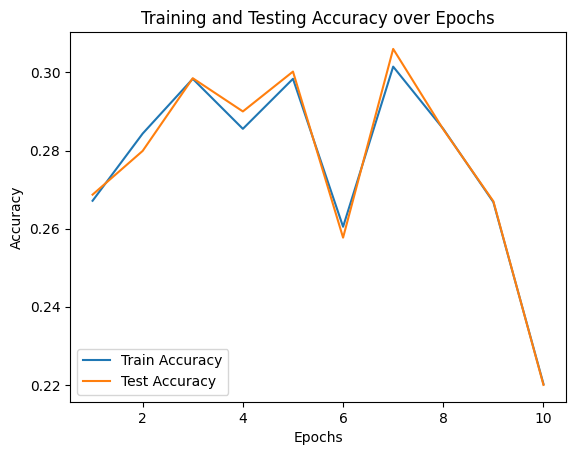

In [12]:
# Sigmoid + adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

Epoch 1: 1.77s, train acc=0.68, train loss=11.28, test acc=0.68, test loss=11.25
Epoch 2: 3.76s, train acc=0.57, train loss=12.25, test acc=0.59, test loss=12.20
Epoch 3: 5.69s, train acc=0.55, train loss=12.05, test acc=0.56, test loss=12.02
Epoch 4: 8.57s, train acc=0.53, train loss=16.49, test acc=0.53, test loss=16.48
Epoch 5: 10.39s, train acc=0.51, train loss=15.58, test acc=0.51, test loss=15.56
Epoch 6: 12.24s, train acc=0.53, train loss=15.08, test acc=0.53, test loss=15.06
Epoch 7: 14.10s, train acc=0.55, train loss=13.26, test acc=0.56, test loss=13.23
Epoch 8: 15.96s, train acc=0.49, train loss=14.84, test acc=0.51, test loss=14.81
Epoch 9: 17.81s, train acc=0.41, train loss=15.09, test acc=0.42, test loss=15.07
Epoch 10: 19.67s, train acc=0.44, train loss=20.24, test acc=0.44, test loss=20.23


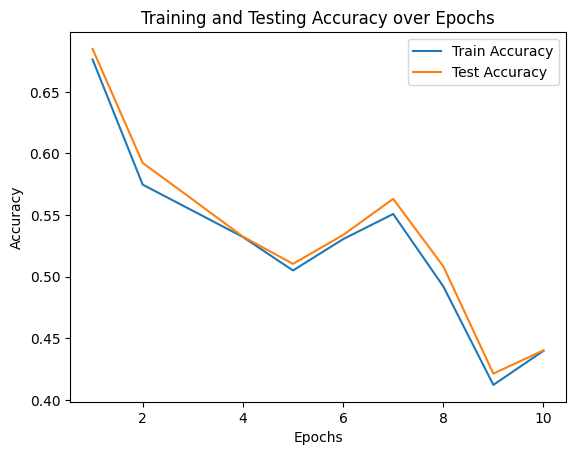

In [13]:
# ReLU + adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.1, beta=.9, lambda1=0.01, lambda2=0.01)

**Kod kaynak:** https://github.com/lionelmessi6410/Neural-Networks-from-Scratch/blob/main/NN-from-Scratch.ipynb